In [1]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

trading_1m.shape


(2831040, 6)

In [2]:
np.save("data/btc_1m.npy", trading_1m)

In [3]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(2831040, 6)

In [4]:
# import os

# import pandas as pd
# from jesse.utils import numpy_candles_to_dataframe
# from pandarallel import pandarallel

# pandarallel.initialize(nb_workers=os.cpu_count() - 1, progress_bar=True)

# from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy
# from custom_indicators.volitility_indicator.yang_zhang import yang_zhang_volatility

# df = numpy_candles_to_dataframe(candles)
# df["vol_150"] = yang_zhang_volatility(candles, period=150, sequential=True)
# df["vol_360"] = yang_zhang_volatility(candles, period=360, sequential=True)
# df["window"] = 150
# df["window_on_vol"] = df["window"] * df["vol_360"] / df["vol_150"]

# c_arr = df["close"].to_numpy()
# lag_arr = df["window_on_vol"].to_numpy()
# log_ret = [
#     np.log(c_arr[i] / c_arr[-round(lag) + i : i]) if np.isfinite(lag) else np.nan
#     for i, lag in zip(range(len(lag_arr)), lag_arr)
# ]
# df["log_ret"] = pd.Series(log_ret, index=df.index)
# df["samp_en"] = df["log_ret"].parallel_apply(
#     lambda x: sample_entropy(x) if isinstance(x, np.ndarray) else np.nan
# )

# df

In [1]:
import os

import numpy as np
import optuna
from mpire import WorkerPool
from numba import njit
from scipy import stats

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.volitility_indicator.yang_zhang import yang_zhang_volatility


@njit(cache=True)
def log_ret(candles: np.ndarray, window_on_vol: np.ndarray) -> list[np.ndarray]:
    log_ret_list = []
    for idx, w_on_vol in enumerate(window_on_vol):
        if np.isfinite(w_on_vol):
            w_on_vol = round(w_on_vol)
            if idx - w_on_vol >= 0:
                log_ret_list.append(
                    np.log(candles[idx, 2] / candles[idx - w_on_vol : idx, 2])
                )
    return log_ret_list


In [2]:
def objective(trial: optuna.Trial) -> float:
    MIN_WINDOW = 20
    MAX_WINDOW = 60 * 24

    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    vol_t_window = trial.suggest_int("vol_t", 20, 360)
    vol_ref_window = trial.suggest_int("vol_ref", vol_t_window, 60 * 24)
    vol_t = yang_zhang_volatility(candles, period=vol_t_window, sequential=True)
    vol_ref = yang_zhang_volatility(candles, period=vol_ref_window, sequential=True)

    window = trial.suggest_int("window", 20, 360)
    window_on_vol = window * vol_ref / (vol_t + 1e-10)
    window_on_vol = np.clip(window_on_vol, MIN_WINDOW, MAX_WINDOW)

    log_ret_list = log_ret(candles, window_on_vol)
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)

    len_gap = len(candles) - len(entropy_array)
    candles = candles[len_gap:]
    window_on_vol = np.round(window_on_vol[len_gap:])
    is_div_window = trial.suggest_categorical("is_div_window", [True, False])
    if is_div_window:
        entropy_array = entropy_array / window_on_vol

    threshold_min = np.sum(entropy_array) / (len(candles) // 20)
    threshold_max = np.sum(entropy_array) / (len(candles) // 360)
    entropy_threshold = trial.suggest_float(
        "entropy_threshold", threshold_min, threshold_max
    )
    merged_bar = build_bar_by_cumsum(
        candles, entropy_array, entropy_threshold, reverse=False
    )
    if len(merged_bar) < len(candles) // 361:
        return 500
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


TRIALS = 1500

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.NopPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=TRIALS, n_jobs=1, gc_after_trial=True)


[I 2025-05-26 16:45:21,660] A new study created in memory with name: no-name-bf214bfe-7b51-42f6-93d8-3704c1b70082
[I 2025-05-26 16:46:07,278] Trial 0 finished with value: 76.17167980904941 and parameters: {'vol_t': 49, 'vol_ref': 385, 'window': 20, 'is_div_window': True, 'entropy_threshold': 1.1444704199515632}. Best is trial 0 with value: 76.17167980904941.
[I 2025-05-26 16:47:30,909] Trial 1 finished with value: 32.695376539038925 and parameters: {'vol_t': 65, 'vol_ref': 350, 'window': 257, 'is_div_window': True, 'entropy_threshold': 0.026856836819387258}. Best is trial 1 with value: 32.695376539038925.
[I 2025-05-26 16:48:49,973] Trial 2 finished with value: 32.68516549761154 and parameters: {'vol_t': 189, 'vol_ref': 1156, 'window': 222, 'is_div_window': True, 'entropy_threshold': 0.04344341681346555}. Best is trial 2 with value: 32.68516549761154.
[I 2025-05-26 16:50:06,796] Trial 3 finished with value: 13.994316179898293 and parameters: {'vol_t': 222, 'vol_ref': 897, 'window': 222

In [3]:
study.best_params

{'vol_t': 41,
 'vol_ref': 1147,
 'window': 117,
 'is_div_window': False,
 'entropy_threshold': 26.658507359843483}

In [ ]:
"""
MIN_WINDOW = 20
MAX_WINDOW = 60 * 24
{
 'vol_t': 41,
 'vol_ref': 1147,
 'window': 117,
 'is_div_window': False,
 'entropy_threshold': 26.658507359843483
}
"""

In [11]:
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles = candles[candles[:, 5] > 0]
MIN_WINDOW = 20
MAX_WINDOW = 60 * 24

vol_t_window = 41
vol_ref_window = 1147
window = 117
entropy_threshold = 26.658507359843483

vol_t = yang_zhang_volatility(candles, period=vol_t_window, sequential=True)
vol_ref = yang_zhang_volatility(candles, period=vol_ref_window, sequential=True)

window_on_vol = window * vol_ref / (vol_t + 1e-10)
window_on_vol = np.clip(window_on_vol, MIN_WINDOW, MAX_WINDOW)

log_ret_list = log_ret(candles, window_on_vol)
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)

len_gap = len(candles) - len(entropy_array)
candles = candles[len_gap:]
window_on_vol = np.round(window_on_vol[len_gap:])

merged_bar = build_bar_by_cumsum(
    candles, entropy_array, entropy_threshold, reverse=False
)
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
print(kurtosis)

14.586684090041977


In [5]:
merged_bar[-1, 0]

1735688520000.0

In [6]:
from jesse import helpers, research

from custom_indicators.toolbox.bar.entropy_bar_v2 import EntropyBarContainer

vol_t_window = 41
vol_ref_window = 1147
window = 117
entropy_threshold = 26.658507359843483
entropy_bar_container = EntropyBarContainer(
    window, vol_t_window, vol_ref_window, entropy_threshold
)

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles = candles[candles[:, 5] > 0]

entropy_bar_container.update_with_candle(candles)
entropy_bar_container.get_entropy_bar()[-1, 0]

1747694220000.0

In [7]:
merged_bar = entropy_bar_container.get_entropy_bar()
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

10.379786390803675

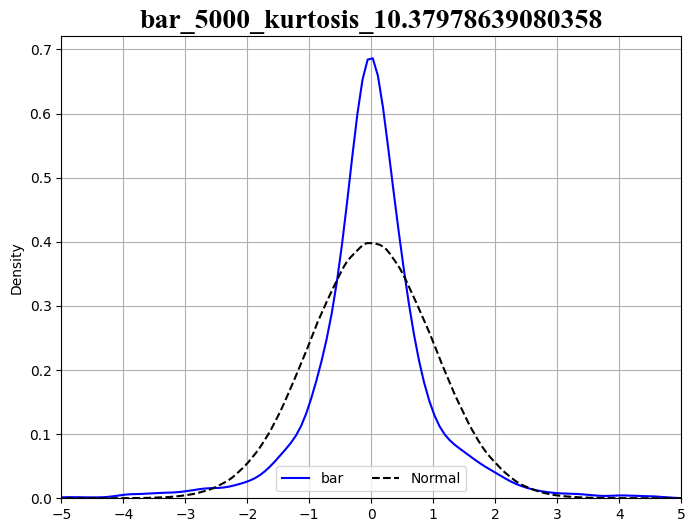

In [8]:
from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2])

In [9]:
from jesse.utils import numpy_candles_to_dataframe
from lightweight_charts import Chart

df_merged_bar = numpy_candles_to_dataframe(merged_bar)

chart = Chart()
chart.set(df_merged_bar[["date", "open", "high", "low", "close", "volume"]])
chart.show(block=True)


RuntimeError: asyncio.run() cannot be called from a running event loop